In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import chi2_contingency
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import joblib
import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sales_data = pd.read_csv("train_v9rqX0R.csv")
validation_data = pd.read_csv("test_AbJTz2l.csv")

In [ ]:
#Feature Engineering

sales_data['Outlet_Age'] = 2025 - sales_data['Outlet_Establishment_Year']
sales_data['Item_Visibility'] = sales_data['Item_Visibility']*100
sales_data['Item_Fat_Content'] = sales_data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'
})

In [4]:
categorical_cols = sales_data.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Columns:", categorical_cols)

Categorical Columns: ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [ ]:

def impute_outlet_size(row):
    if pd.isna(row['Outlet_Size']) or row['Outlet_Size'] == 'Missing':
        year = row['Outlet_Establishment_Year']
        otype = row['Outlet_Type']
        loc = row['Outlet_Location_Type']
        
        if year == 1987:
            return 'High'
        elif otype == 'Supermarket Type3':
            return 'Medium'
        elif otype == 'Grocery Store':
            return 'Small'
        elif loc == 'Tier 2':
            return 'Small'
        elif year in [1997, 2004]:
            return 'Small'
        elif year in [1999, 2009]:
            return 'Medium'
        elif year == 1985:
            if otype == 'Supermarket Type1':
                return 'Medium'
            elif otype == 'Grocery Store':
                return 'Small'
    else:
        return row['Outlet_Size']
    
sales_data['Outlet_Size'] = sales_data.apply(impute_outlet_size, axis=1)

sales_data['Item_Weight'] = sales_data.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))




In [6]:
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    sales_data[col] = le.fit_transform(sales_data[col])
    encoders[col] = le


In [7]:
train_data, test_data = train_test_split(sales_data, test_size=0.2, random_state=42, shuffle=True)

In [8]:
X_train = train_data.drop('Item_Outlet_Sales', axis=1)
y_train = train_data['Item_Outlet_Sales']
X_test = test_data.drop('Item_Outlet_Sales', axis=1)
y_test = test_data['Item_Outlet_Sales']

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Hyperparameters:
{'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}

Mean Squared Error (MSE): 1056824.8658
Root Mean Squared Error (RMSE): 1028.0199
Mean Absolute Error (MAE): 721.1165
R2 Score: 0.6112


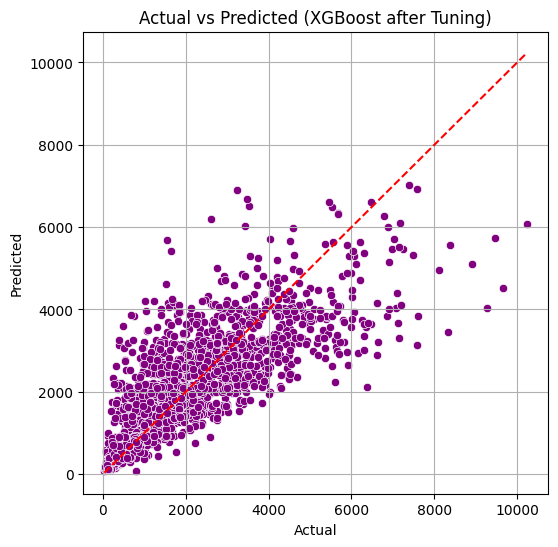

In [ ]:

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5]
}

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=30,   
    scoring='neg_mean_absolute_error',
    cv=5,      
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("\nBest Hyperparameters:")
print(random_search.best_params_)

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

# 7. Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

# 8. Plot Actual vs Predicted
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (XGBoost after Tuning)')
plt.grid(True)
plt.show()


In [10]:
# TESTING ON VALIDATION DATA

In [ ]:
id_column = validation_data[['Item_Identifier', 'Outlet_Identifier']]
validation_data['Outlet_Age'] = 2025 - validation_data['Outlet_Establishment_Year']
validation_data['Item_Visibility'] = validation_data['Item_Visibility']*100
validation_data['Item_Fat_Content'] = validation_data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'
})


validation_data['Outlet_Size'] = validation_data.apply(impute_outlet_size, axis=1)

validation_data['Item_Weight'] = validation_data.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))

# Apply the saved encoders to new data
for col in categorical_cols:
    validation_data[col] = encoders[col].transform(validation_data[col])

In [12]:
validation_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age
0,1114,20.750,1,0.756484,13,107.8622,9,1999,1,0,1,26
1,1078,8.300,4,3.842768,4,87.3198,2,2007,2,1,1,18
2,1420,14.600,1,9.957491,11,241.7538,0,1998,2,2,0,27
3,817,7.315,1,1.538839,13,155.0340,2,2007,2,1,1,18
4,1197,13.600,2,11.859931,4,234.2300,5,1985,1,2,3,40
...,...,...,...,...,...,...,...,...,...,...,...,...
5676,233,10.500,2,1.349647,13,141.3154,8,1997,2,0,1,28
5677,308,7.600,2,14.299090,15,169.1448,3,2009,1,2,2,16
5678,1426,10.000,1,7.352856,8,118.7440,7,2002,2,1,1,23
5679,521,15.300,2,0.000000,3,214.6218,2,2007,2,1,1,18


In [13]:
y_pred = best_model.predict(validation_data)

In [ ]:
id_column_reset = id_column.reset_index(drop=True)
test_data_reset = test_data.reset_index(drop=True)

predictions = pd.DataFrame({
    'Item_Identifier': id_column_reset['Item_Identifier'],
    'Outlet_Identifier': id_column_reset['Outlet_Identifier'],
    'Predicted_Sales': y_pred
})

print(predictions.head())
predictions.columns = ["Item_Identifier","Outlet_Identifier", "Item_Outlet_Sales" ]
predictions.to_csv("prediction_1.csv")

  Item_Identifier Outlet_Identifier  Predicted_Sales
0           FDW58            OUT049      1679.416382
1           FDW14            OUT017      1377.222412
2           NCN55            OUT010       610.686096
3           FDQ58            OUT017      2479.521729
4           FDY38            OUT027      6227.881348
